In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense 
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import requests
from bs4 import BeautifulSoup  

In [19]:
#삼성 코드 005930
#date 부터 오늘까지 주가 긁어오는 함수
def parse_to_df(code,date):
    page = 1
    while True: 
        url = f'https://finance.naver.com/item/sise_day.nhn?code={code}&page={page}'
        req = requests.get(url) 
        #html 구문에 맞게 텍스트를 읽는다
        bs = BeautifulSoup(req.text, "html.parser")
        print(f'page {page}')
        try : 
            #read_html은 html에서 표를 가져온다
            #0 번째 인덱스를 넣는게 의미가 없어 보일 수 있어도 
            #dataframe이 리스트에 감싸져 나오기 때문에 한 요소만 선택
            table = pd.read_html(str(bs.find('table',{'class':"type2"})))[0] 
            
            #첫페이지일 경우 table을 깊은 복사
            if page == 1:
                df = table.dropna().copy()    
                print('copy dataframe')
            #table을 df에 추가
            else : 
                df = pd.concat([df,table.dropna()])  
                print('concate dataframe')
        except Exception as e :
            print(e)   

        #breaking point date ~ 오늘까지만 남김
        if int(str(df.iloc[-1][0]).replace('.',''))  < int(date) :
            date = date[:4]+'.'+date[4:6]+'.'+date[6:]
            df = df[df['날짜']>= date]  
            print('break')
            break
        page += 1  
    #영어로 column 명 바꿈
    df.columns = ["Date","Close", 'YtT','Market Cap','High','Low','Volume' ]
    return df 

date,code =  input('시작일) YYYYMMDD   code:').split()
df = parse_to_df(code,date)
 

시작일) YYYYMMDD   code:20191101 005930
page 1
copy dataframe
page 2
concate dataframe
page 3
concate dataframe
page 4
concate dataframe
page 5
concate dataframe
page 6
concate dataframe
page 7
concate dataframe
page 8
concate dataframe
page 9
concate dataframe
page 10
concate dataframe
page 11
concate dataframe
page 12
concate dataframe
page 13
concate dataframe
page 14
concate dataframe
page 15
concate dataframe
page 16
concate dataframe
page 17
concate dataframe
page 18
concate dataframe
page 19
concate dataframe
page 20
concate dataframe
break


In [20]:
df.tail()

,Date,Close,YtT,Market Cap,High,Low,Volume
11,2019.11.07,52900.0,400.0,53400.0,53400.0,52400.0,9257116.0
12,2019.11.06,53300.0,600.0,52900.0,53500.0,52700.0,14361133.0
13,2019.11.05,52700.0,400.0,52400.0,52700.0,52100.0,10581034.0
1,2019.11.04,52300.0,1100.0,51700.0,52300.0,51400.0,13012411.0
2,2019.11.01,51200.0,800.0,50600.0,51200.0,50400.0,8467846.0


In [21]:
#df 를 csv로 저장
df.to_csv(f'./{code}_crawling.csv', sep=',',index=False)

In [22]:
data = pd.read_csv(f'./{code}_crawling.csv')
data

,Date,Close,YtT,Market Cap,High,Low,Volume
0,2020.08.07,57500.0,500.0,57900.0,58400.0,57100.0,18160383.0
1,2020.08.06,58000.0,1100.0,57100.0,58400.0,57100.0,21625874.0
2,2020.08.05,56900.0,400.0,57300.0,57500.0,56300.0,17739706.0
3,2020.08.04,57300.0,500.0,57200.0,58100.0,57000.0,19419694.0
4,2020.08.03,56800.0,1100.0,57800.0,57900.0,56700.0,21158940.0
...,...,...,...,...,...,...,...
187,2019.11.07,52900.0,400.0,53400.0,53400.0,52400.0,9257116.0
188,2019.11.06,53300.0,600.0,52900.0,53500.0,52700.0,14361133.0
189,2019.11.05,52700.0,400.0,52400.0,52700.0,52100.0,10581034.0
190,2019.11.04,52300.0,1100.0,51700.0,52300.0,51400.0,13012411.0


In [23]:
high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices) / 2 

In [24]:
print('총 데이터의 수 : ',len(data))
seq_len = int(input('최근 몇일을 반영할 지 입력하세요. '))  

#LSTM input을 넣어주기 위해 50개의 데이터를 리스트로 가지는 데이터
# 총 개수 = 총 데이터 수(행의 수) - window 수 - 1
# -1은 예측이 될 output을 생각해서 더해줌
result = []
for index in range(len(mid_prices) - seq_len -1):
    result.append(mid_prices[index: index + seq_len+1])
print('result appended')

총 데이터의 수 :  192
최근 몇일을 반영할 지 입력하세요. 50
result appended


In [25]:
def normalize_windows(result):
    normalized_data = []
    for window in result:
        #float(window[0])을 기준으로 정규화를 진행함
        normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalized_data.append(normalized_window)
    return np.array(normalized_data)

result = normalize_windows(result)
# split train and test data
#LSTM input 형식으로 분리한 데이터 양 = result.shape[0]
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]

#섞어준다
np.random.shuffle(train)

x_train = train[:, :-1]
#x_train.shape[0] = 행의 수 
#x_train.shape[1] = 처음에 고른 window 크기
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((127, 50, 1), (14, 50, 1))

In [28]:
model = Sequential()

#seq_len개 데이터가 들어감 각 seq 에서 아웃풋 냄
model.add(LSTM(seq_len, return_sequences=True, input_shape=(seq_len, 1)))

#마지막 seq만 내보냄
model.add(LSTM(64, return_sequences=False))

model.add(Dense(1,activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


In [31]:
from datetime import datetime

start_time = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=20,
    callbacks=[
        TensorBoard(log_dir='logs/%s' % (start_time)),
        #epoch마다 가중치를 저장하는데 /val_loss 가 좋을 때만
        ModelCheckpoint('./models/%s_eth.h5' % (start_time), monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        #AttributeError: 'Sequential' object has no attribute '_get_distribution_strategy'
        #val_loss 기준 / callback되면 학습률 0.2 / patience epoch 6 동안 기다렸다가 callback
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto')
])

Train on 127 samples, validate on 14 samples


AttributeError: 'Sequential' object has no attribute '_get_distribution_strategy'

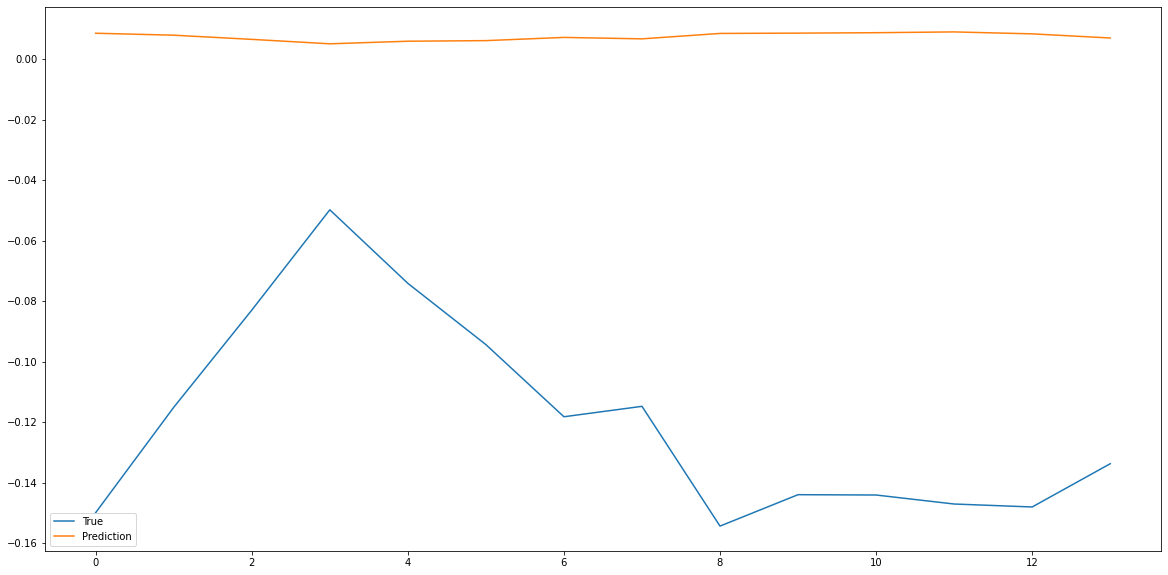

In [12]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()